In [1]:
pip install deepxde

     |████████████████████████████████| 121 kB 13.3 MB/s 
     |████████████████████████████████| 100 kB 8.2 MB/s 


Compiling model...
Building feed-forward neural network...
'build' took 0.157666 s



/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+3002=3002. 
  total_n_samples))
/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 1.832873 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.71e+02, 5.07e-01]    [1.71e+02, 5.06e-01]    []  
1000      [6.42e-05, 8.90e-05]                                
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000108
  Number of iterations: 1089
  Number of functions evaluations: 1233
1233      [4.66e-05, 6.10e-05]    [4.32e-05, 6.10e-05]    []  

Best model at step 1233:
  train loss: 1.08e-04
  test loss: 1.04e-04
  test metric: []

'train' took 307.881728 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


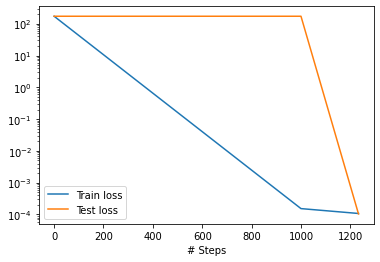

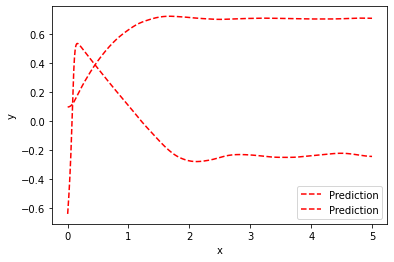

In [31]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
from deepxde.backend import tf

I = 6
V0 = -0.65
R0= 0.097

def func(t, x):
    V, R = x
    dx_t = (-(17.81+47.71*V+32.63*V*V)*(V-0.55)-26.0*R*(V+0.92)+I)
    dy_t = (-R+1.35*V+1.03)/1.9
    return dx_t, dy_t

def ode_system(x, y):
    V = y[:, 0:1]
    R = y[:, 1:2]
    dr_t = dde.grad.jacobian(y, x, i=0)
    dp_t = dde.grad.jacobian(y, x, i=1)
    return [
        dr_t - (-(17.81+47.71*V+32.63*V*V)*(V-0.55)-26.0*R*(V+0.92)+I),
        dp_t - (-R+1.35*V+1.03)/1.9,
    ]


geom = dde.geometry.TimeDomain(0.0, 5.0)
data = dde.data.PDE(geom, ode_system, [], 3000, 2, num_test=3000)

layer_size = [1] + [64] * 6 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

def input_transform(t):
    return tf.concat(
        (
            t,
            tf.sin(t),
            tf.sin(2 * t),
            tf.sin(3 * t),
            tf.sin(4 * t),
            tf.sin(5 * t),
            tf.sin(6 * t),
        ),
        axis=1,
    )
def output_transform(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    return tf.concat([y1 * tf.tanh(t) + V0, y2 * tf.tanh(t) + R0], axis=1)


net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)
model = dde.Model(data, net)

model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


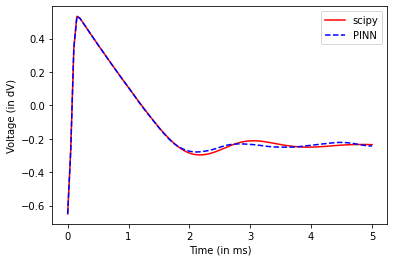

In [35]:
def gen_truedata():
    t = np.linspace(0, 5.0, 100)

    sol = integrate.solve_ivp(func, (0.0, 5.0), (V0, R0), t_eval=t)
    x_true, y_true = sol.y
    x_true = x_true.reshape(100, 1)
    y_true = y_true.reshape(100, 1)

    return x_true, y_true

plt.xlabel("Time (in ms)")
plt.ylabel("Voltage (in dV)")

t = np.linspace(0, 5, 100)
x_true, y_true = gen_truedata()
plt.plot(t, x_true, color="red", label="scipy")

t = t.reshape(100, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
plt.plot(t, x_pred, color="blue", linestyle="dashed", label="PINN")
plt.legend()
plt.show()